In [1]:
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import scipy.optimize as spopt 
import scipy.fftpack as spfft 
import scipy.ndimage as spimg 
import cvxpy as cvx
import imageio
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

In [3]:
# 원본 이미지 읽기 및 속도 축소
Xorig = imageio.imread('cbnu.jpg', as_gray=True, pilmode='L') # 그레이 스케일로 읽기

In [4]:
X = spimg.zoom(Xorig, 0.1)
ny,nx = X.shape

Text(0.5, 1.0, 'downsized image')

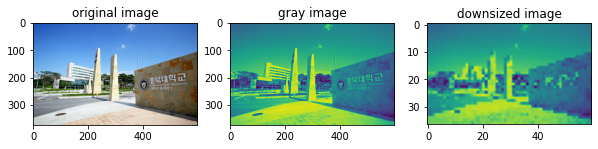

In [5]:
plt.figure(figsize=(10, 8))
plt.subplot(131)
img = mpimg.imread('cbnu.jpg')
imgplot = plt.imshow(img)
plt.title("original image")

plt.subplot(132)
imgplot = plt.imshow(Xorig)
plt.title("gray image")

plt.subplot(133)
imgplot = plt.imshow(X)
plt.title("downsized image")

In [6]:
# 작은 신호 샘플 추출
k = round(nx * ny * 0.5) # 50% sample
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = X.T.flat[ri]
b2 = np.expand_dims(b, axis=1)

In [7]:
# kron 을 사용하여 dct 행렬 연산자 생성(memory errors for large ny*nx)
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )
A = A[ri,:] # same as phi times kron

In [8]:
# do L1 optimization
vx = cvx.Variable(nx * ny)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == b]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
Xat2 = np.array(vx.value).squeeze()

                                     CVXPY                                     
                                    v1.1.11                                    
(CVXPY) May 18 12:20:50 PM: Your problem has 2220 variables, 1 constraints, and 0 parameters.
(CVXPY) May 18 12:20:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 18 12:20:50 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 18 12:20:50 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 18 12:20:50 PM: Compiling problem (target solver=ECOS).
(CVXPY) May 18 12:20:50 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

C:\Anaconda\envs\test\lib\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) May 18 12:20:51 PM: Applying reduction ECOS
(CVXPY) May 18 12:20:52 PM: Finished problem compilation (took 1.562e+00 seconds).
(CVXPY) May 18 12:20:52 PM: (Subsequent compilations of this problem, using the same arguments, should take less time.)
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) May 18 12:20:52 PM: Invoking solver ECOS to obtain a solution.

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +8e+06  1e+00  1e-02  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  +7.843e+03  +7.984e+03  +3e+06  9e-01  5e-03  1e+02  7e+02  0.6530  1e-01   1  0  1 |  0  0
 2  +1.183e+04  +1.187e+04  +5e+05  5e-01  7e-04  4e+01 

In [9]:
# 신호 재구성
Xat = Xat2.reshape(nx, ny).T # stack columns
Xa = idct2(Xat)

In [10]:
# confirm solution
if not np.allclose(X.T.flat[ri], Xa.T.flat[ri]):
    print('Warning: values at sample indices don\'t match original.')

In [11]:
# 마스크 이미지 생성 (시각화 용)
mask = np.zeros(X.shape)
mask.T.flat[ri] = 255
Xm = 255 * np.ones(X.shape)
Xm.T.flat[ri] = X.T.flat[ri]

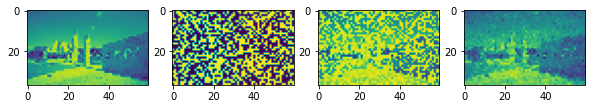

In [12]:
plt.figure(figsize=(10, 8))
plt.subplot(141)
imgplot = plt.imshow(X)

plt.subplot(142)
imgplot = plt.imshow(mask)

plt.subplot(143)
imgplot = plt.imshow(Xm)

plt.subplot(144)
imgplot = plt.imshow(Xa)